In [96]:
import numpy as np 
import pandas as pd 

In [97]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [98]:
train_data = pd.read_csv('C:/Users/王沛/Desktop/train.csv',index_col=0)
train_y = train_data['SalePrice']
train_data.drop(['SalePrice'],axis=1,inplace=True)

data = train_data
features = data.columns
sns.set_style('whitegrid')

In [99]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [100]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [101]:
def Na_rate(data):
    na_df = pd.DataFrame(columns=['feature_name','na_rate'])
    na_rate = []
    for i in data.columns:
        rate = data[i].isnull().sum()*1.0/len(data[i])
        na_rate.append(rate)
        
    na_df['feature_name'] = features
    na_df['na_rate'] = na_rate
    na_df = na_df[na_df['na_rate']!=0].sort_values(by='na_rate',ascending=False)
    print('miss_features_num',na_df.shape[0])
    return na_df

def Dis_features(data):
    cat_features = []
    num_features = []
    for i in data.columns:
        if data[i].dtype == 'object':
            cat_features.append(i)
        else:
            num_features.append(i)
    if 'Id' in num_features:
        num_features.remove('Id')
    print('Категориальные признаки：',len(cat_features))
    print('Числовые признаки：',len(num_features))
    
    return cat_features,num_features

def Fill_reason_missing(data,features):
    data1 = data.copy()
    for i in features:
        data1[i] = data1[i].fillna(-1)
        data1[i] = data1[i].map(lambda x:x if x==-1 else 1)
    return data1
def Fill_num_miss(data,col):
    data1 = data.copy()
    for i in col:
        data1[i] = SimpleImputer().fit_transform(data1[i].values.reshape(-1,1))
    return data1
def Fill_cat_miss(data,col):
    data1 = data.copy()
    for i in col:
        data1[i] = data1[i].fillna(data1[i].dropna().mode()[0])
    return data1
#кодирование категориальных признаков
def Cat_encoder(data,col):
    data1 = data.copy()
    for i in col:
        data1[i] = pd.factorize(data1[i])[0]
    return data1
#нормализацию числовых признаков
def Standard_num(data,col):
    data1 = data.copy()
    for i in col:
        data1[i] = StandardScaler().fit_transform(data1[i].values.reshape(-1,1))
    return data1

Отклонение： 1.8828757597682129
Эксцесс： 6.536281860064529


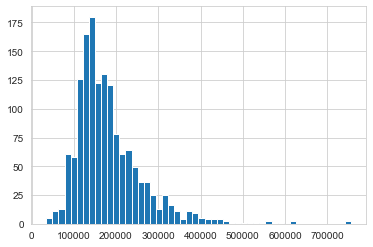

In [102]:
print('Отклонение：',train_y.skew())
print('Эксцесс：',train_y.kurt())
train_y.hist(bins=50)
plt.show()

In [103]:
#Нормальное распределение смещено вправо

Отклонение： 0.12134661989685333
Эксцесс： 0.809519155707878


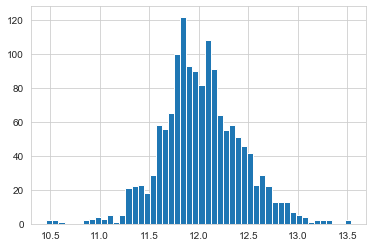

In [104]:
log_train_y = np.log(1+train_y)
print('Отклонение：',log_train_y.skew())
print('Эксцесс：',log_train_y.kurt())
log_train_y.hist(bins=50)
plt.show()

In [105]:
cat_all, num_all = Dis_features(data)

Категориальные признаки： 43
Числовые признаки： 36


In [106]:
na_train = Na_rate(train_data)
print(na_train)


miss_features_num 19
    feature_name   na_rate
71        PoolQC  0.995205
73   MiscFeature  0.963014
5          Alley  0.937671
72         Fence  0.807534
56   FireplaceQu  0.472603
2    LotFrontage  0.177397
57    GarageType  0.055479
58   GarageYrBlt  0.055479
59  GarageFinish  0.055479
62    GarageQual  0.055479
63    GarageCond  0.055479
31  BsmtExposure  0.026027
34  BsmtFinType2  0.026027
32  BsmtFinType1  0.025342
30      BsmtCond  0.025342
29      BsmtQual  0.025342
25    MasVnrArea  0.005479
24    MasVnrType  0.005479
41    Electrical  0.000685


In [107]:
na_all = Na_rate(data)
print(na_all)
miss_40_features = na_all[na_all['na_rate']>0.4]['feature_name'].values

miss_features_num 19
    feature_name   na_rate
71        PoolQC  0.995205
73   MiscFeature  0.963014
5          Alley  0.937671
72         Fence  0.807534
56   FireplaceQu  0.472603
2    LotFrontage  0.177397
57    GarageType  0.055479
58   GarageYrBlt  0.055479
59  GarageFinish  0.055479
62    GarageQual  0.055479
63    GarageCond  0.055479
31  BsmtExposure  0.026027
34  BsmtFinType2  0.026027
32  BsmtFinType1  0.025342
30      BsmtCond  0.025342
29      BsmtQual  0.025342
25    MasVnrArea  0.005479
24    MasVnrType  0.005479
41    Electrical  0.000685


In [108]:
print('Train：')
missing_data_train = train_data[na_train['feature_name'].values]
cat_miss_train, num_miss_train = Dis_features(missing_data_train)
print(num_miss_train)

Train：
Категориальные признаки： 16
Числовые признаки： 3
['LotFrontage', 'GarageYrBlt', 'MasVnrArea']


In [109]:
data['LotFrontage'] = SimpleImputer().fit_transform(data['LotFrontage'].values.reshape(-1,1))
for i in num_miss:
    data[i] = data[i].fillna(-1)
    

missing_data = data[na_all2['feature_name'].values]
Dis_features(missing_data)


Категориальные признаки： 16
Числовые признаки： 0


(['PoolQC',
  'MiscFeature',
  'Alley',
  'Fence',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'BsmtExposure',
  'BsmtFinType2',
  'BsmtQual',
  'BsmtCond',
  'BsmtFinType1',
  'MasVnrType',
  'Electrical'],
 [])

In [110]:
fill_cat = na_all2[na_all2['na_rate']<0.02]['feature_name'].values
print(data['MasVnrType'].value_counts())
print('==========')
print(fill_cat)
data = Fill_cat_miss(data,fill_cat)
na_all3 = Na_rate(data)
print('==========')
print(na_all3)

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
['MasVnrType' 'Electrical']
miss_features_num 14
    feature_name   na_rate
71        PoolQC  0.995205
73   MiscFeature  0.963014
5          Alley  0.937671
72         Fence  0.807534
56   FireplaceQu  0.472603
57    GarageType  0.055479
59  GarageFinish  0.055479
62    GarageQual  0.055479
63    GarageCond  0.055479
31  BsmtExposure  0.026027
34  BsmtFinType2  0.026027
29      BsmtQual  0.025342
30      BsmtCond  0.025342
32  BsmtFinType1  0.025342


Кодирование категориальных признаков

In [111]:
print('cat：',cat_all)
print('='*50)
print('num:',num_all)
data = Cat_encoder(data,cat_all)

cat： ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF

In [112]:
Na_rate(data)

miss_features_num 0


,feature_name,na_rate


Нормализацию числовых признаков

In [113]:
data = Standard_num(data,num_all)

In [114]:
for i in cat_all:
    length = len(set(data[i].values))
    print(i,length)

MSZoning 5
Street 2
Alley 3
LotShape 4
LandContour 4
Utilities 2
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 7
FireplaceQu 6
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
PoolQC 4
Fence 5
MiscFeature 5
SaleType 9
SaleCondition 6
